## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 20, 12

In [ ]:
## Check current working directory
os.chdir('/Users/gisellekurniawan/Documents/stats_101c')
print('Current working directory: ', os.getcwd())

Current working directory:  /Users/gisellekurniawan/Documents/stats_101c


In [ ]:
## Reading our data 
data = pd.read_csv("Data_Final")

In [ ]:
data.head()

**We decided to work on two different models: KNN and Logistic Regression for its ability to solve classification problems**

### Data Analysis to Prepare LR Model

In [ ]:
# To attain better results, I only took reviews with polar opposite ratings 1 or 5. A rating of 1 equals negative, and a rating of 5 equals positive
negative_reviews=data[data['Star']==1]
positive_reviews=data[data['Star']==5]

In [ ]:
# Since the indexes of our values in negative_results and positive_results are still from the original data, we should reset index
negative_reviews=negative_reviews.reset_index(drop=True)
positive_reviews=positive_reviews.reset_index(drop=True)

In [ ]:
positive_reviews=positive_reviews[['Review']]
positive_reviews['class'] = 'positive'

In [ ]:
negative_reviews=negative_reviews[['Review']]
negative_reviews['class'] = 'negative'

In [ ]:
# UNIONs negative and positive reviews into one dataframe
sentiment=pd.concat([negative_reviews,positive_reviews])

<AxesSubplot:>

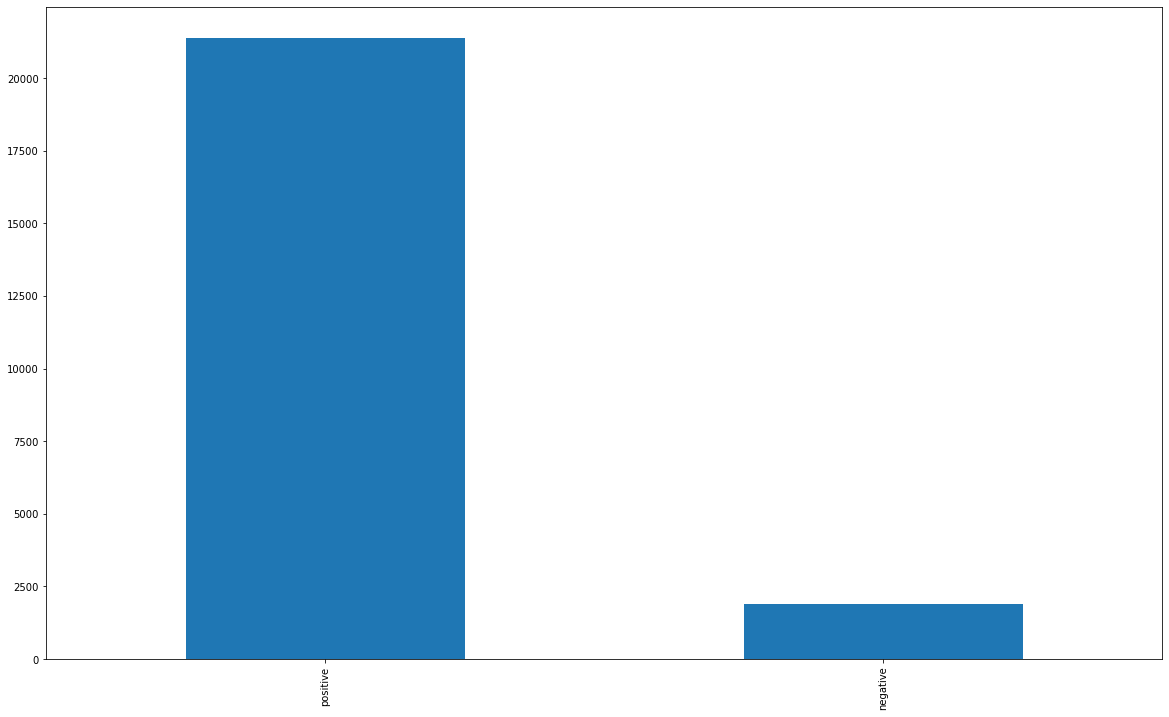

In [ ]:
sentiment['class'].value_counts().plot.bar()

## Data Cleaning

**To check if we need to remove any outliers, the first metric I will look at is the word count for each review**

In [ ]:
# Create a new column called 'word count' that count the number of words in each review
data['word_count'] = data['Review'].apply(lambda x: len(str(x).split()))

Text(0, 0.5, 'Number of Words')

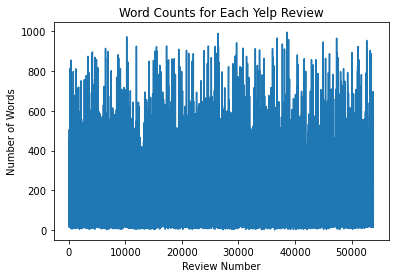

In [ ]:
##fig = plt.figure()
data['word_count'].plot()
plt.title('Word Counts for Each Yelp Review')
plt.xlabel('Review Number') 
plt.ylabel('Number of Words')
##fig.savefig('word_count.png')

From the plot above, it seems like most reviews are under 1000 words, so we don't have to remove any outliers.

**Cleaning Review Column**

Next, to prepare our "Review" data for sentiment analysis, we decided on several steps:  
- Removing Stop words (e.g "the", "a", "an") -> to make overall meaning of each review more meaningful
- Removing any digits
- Convert all text to lower case -> to make finding similar vectors easier
- Removign any punactuation

In [ ]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
from string import digits, punctuation

In [ ]:
stop = stopwords.words('english')

In [ ]:
sentiment

,Review,class,clean_review
0,"When I received my to-go order, I asked for a ...",negative,when i received togo order i asked couple cups...
1,Terrible. I know padero beach is suppose to be...,negative,terrible i know padero beach suppose gauche pl...
2,I'm sure running a sushi restaurant must be ha...,negative,im sure running sushi restaurant must hard but...
3,Its baffling how Rusty's became the most proli...,negative,its baffling rustys became prolific pizza join...
4,Extremely disappointed by my stay here. For th...,negative,extremely disappointed stay here for first tim...
...,...,...,...
21383,This is the best vegan restaurant in Californi...,positive,this best vegan restaurant california accordin...
21384,We've used Jerry The Plumber for water heater ...,positive,weve used jerry the plumber water heater repai...
21385,"Wow, talk about some of the best deals I've ev...",positive,wow talk best deals ive ever seen grocery item...
21386,My Husband and I decided to stop into Hook and...,positive,my husband i decided stop hook press minimoon ...


In [ ]:
### Removes Stopwords
sentiment['clean_review'] = sentiment['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# Remove Digits
sentiment.clean_review = sentiment.clean_review.apply(lambda x: x.translate(str.maketrans('','',digits)))
# Convert all text to lowercase (better to find similar vectors later)
sentiment.clean_review = sentiment.clean_review.apply(lambda x: x.lower())
# remove punctuation
sentiment.clean_review = sentiment.clean_review.apply(lambda x: x.translate(str.maketrans('','',punctuation)))

## Text Processors

In [ ]:
import re
class ExtraSpacesReplacer(object):
    """ Replaces extra spaces in a text.
    >>> replacer = ExtraSpacesReplacer()
    >>> replacer.replace("and it was excellent.  The weather was perfect")
    'and it was excellent. The weather was perfect'
    """
    
    def replace(self, text):
        s = text
        s = re.sub('\s\s+', ' ', s)
        return s

In [ ]:
# Codes taken from Python 3 Text Processing with NLTK 3 Cookbook - Jacob Perkins

##################################################
## Replacing Words Matching Regular Expressions ##
##################################################

replacement_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'I\'m', 'I am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would'),
]

In [ ]:

class ContractionReplacer(object):
    """ Replaces regular expression in a text.
    >>> replacer = RegexpReplacer()
    >>> replacer.replace("can't is a contraction")
    'cannot is a contraction'
    >>> replacer.replace("I should've done that thing I didn't do")
    'I should have done that thing I did not do'
    """
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    
    def replace(self, text):
        s = text

        for (pattern, repl) in self.patterns:
            s = re.sub(pattern, repl, s)

        return s

In [ ]:
from nltk.corpus import wordnet

class RepeatReplacer(object):
    """ Removes repeating characters until a valid word from dictionary is found.
    >>> replacer = RepeatReplacer()
    >>> replacer.replace('looooove')
    'love'
    >>> replacer.replace('oooooh')
    'ooh'
    >>> replacer.replace('goose')
    'goose'
    """
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'

    def replace(self, word):
        if wordnet.synsets(word):
            return word
        
        repl_word = self.repeat_regexp.sub(self.repl, word)

        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word


In [ ]:
class CarriageReturnReplacer(object):
    """ Replaces \r\n expressions in a text.
    >>> replacer = CarriageReturnReplacer()
    >>> replacer.replace("\r\n\r\nAnyway, I can\'t wait to go back!")
    'Anyway, I can\'t wait to go back!'
    """
    
    def replace(self, text):
        s = text
        s = s.replace('\r\n', ' ')
        s = s.replace('\n\n', ' ') 
        s = s.replace('\n', ' ')
        s = s.replace('\r', ' ') 
        return s

In [ ]:
#import enchant
from nltk.metrics import edit_distance

class SpellingReplacer(object):
    def __init__(self, dict_name='en', max_dist=1):
        self.spell_dict = enchant.Dict(dict_name)
        self.max_dist = max_dist
    
    def replace(self, word):
        if self.spell_dict.check(word):
            return word
    
        suggestions = self.spell_dict.suggest(word)
    
        if suggestions and edit_distance(word, suggestions[0]) <= self.max_dist:
            return suggestions[0]
        else:
            return word


## Applying text processors

In [ ]:
repeat_replacer = RepeatReplacer()
contraction_replacer = ContractionReplacer()
newline_replacer = CarriageReturnReplacer()
spaces_replacer = ExtraSpacesReplacer()


In [ ]:
# replace new line characters
sentiment['clean_review'] = sentiment['clean_review'].apply(newline_replacer.replace)
# replace extra spaces
sentiment['clean_review'] = sentiment['clean_review'].apply(spaces_replacer.replace)
# replace contractions
sentiment['clean_review'] = sentiment['clean_review'].apply(contraction_replacer.replace)

## Word Clouds

In [ ]:
from wordcloud import WordCloud

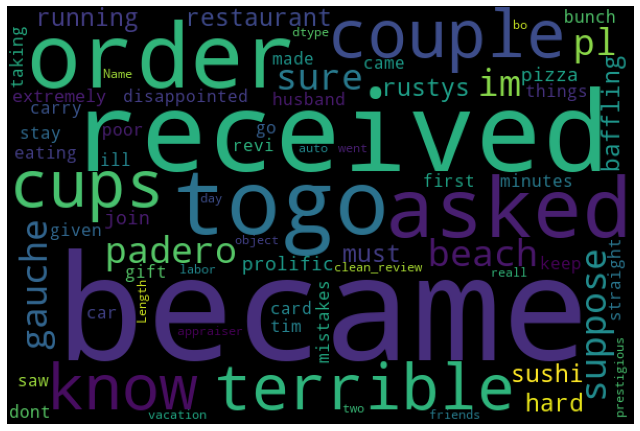

In [ ]:
## Negative Reviews
text=sentiment['clean_review'][sentiment['class']=='negative']
polarity_pos_wordcloud = WordCloud(width=600, height=400).generate(str(text))
plt.figure( figsize=(9,9))
plt.imshow(polarity_pos_wordcloud)
plt.axis("off")
plt.tight_layout()
plt.show()


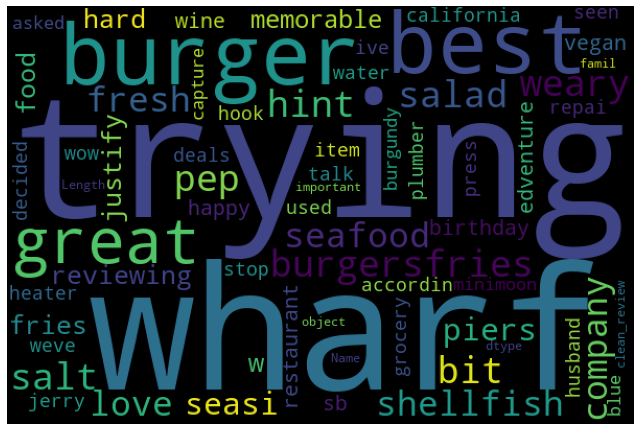

In [ ]:
## Positive Reviews
text=sentiment['clean_review'][sentiment['class']=='positive']
polarity_pos_wordcloud = WordCloud(width=600, height=400).generate(str(text))
plt.figure( figsize=(9,9))
plt.imshow(polarity_pos_wordcloud)
plt.axis("off")
plt.tight_layout()
plt.show()

## Logistic Regression Model

Logistic Regression Model is a classification problem that is used to predict the probability of a categorical dependent variable.
This model will predict whether a rating is **positive** (1) or **negative** (0).

In [ ]:
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [ ]:
X = sentiment.clean_review
y = sentiment['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
# encode categorical data
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder() 
le.fit(y_test) 
le.transform(y_test) 

array([0, 1, 1, ..., 0, 1, 1])

In [ ]:
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer(lowercase=False)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)
# Note that CountVectorizer transforms a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

We use *fit_transform()* on training data as we want to:  
    - Fit: calculate the mean and variance of each of our data's features -> creates a scale for each feature -> allows model to learn about the training data  
    - Transform: Transform all features using the respective mean and variance (parameters)
    
We use *transform()* on testing data as:  
    - To transform() our data based on previous parameters (e.g mean & variance) from our training data  
    - Not using fit will allow us to evaluate how our model is performing on unseen data

In [ ]:
class_names=["negative", "positive"] 

In [ ]:
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 


     

# Create a grid search object for best model estmators
# my laptop wont run this 
from sklearn.model_selection import GridSearchCV
gs_lr = GridSearchCV(estimator=LogReg_pipeline,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10) 
gs_lr.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(ngram_range=(1, 2))),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'clf__C': [1.0, 0.5, 0.1],
                          'clf__penalty': ['l1', 'l2'],
                          'clf__solver': ['liblinear']}],
             scoring='accuracy')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix,accuracy_score

LogReg_pipeline = Pipeline([
               ('vect', CountVectorizer(ngram_range=(1,2) ) ),
               ('tfidf', TfidfTransformer() ),
               ('clf', LogisticRegression()),
                ])


LogReg_pipeline.fit(X_train,y_train)

%time
# predict test instances
y_pred_reg = LogReg_pipeline.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred_reg, y_test))

CPU times: user 79 µs, sys: 26 µs, total: 105 µs
Wall time: 16.2 µs
accuracy 0.9444603492699685


NameError: name 'classification_report' is not defined

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_reg,target_names=class_names))

              precision    recall  f1-score   support

    negative       0.99      0.27      0.42       527
    positive       0.94      1.00      0.97      6459

    accuracy                           0.94      6986
   macro avg       0.96      0.63      0.70      6986
weighted avg       0.95      0.94      0.93      6986



## Plotting Confusion Matrix

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


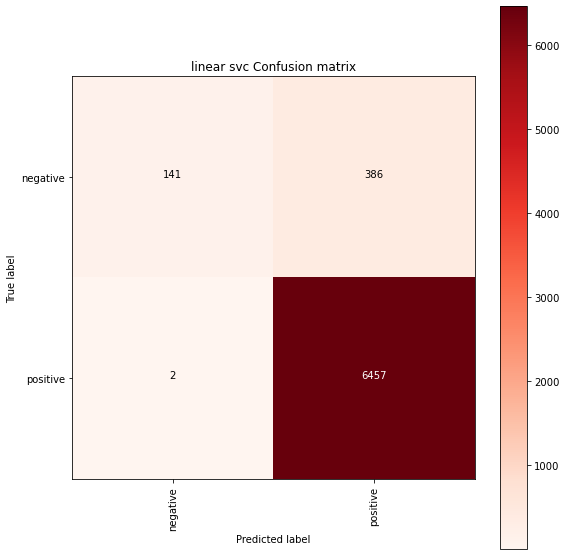

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_reg), classes=class_names,
                      title='linear svc Confusion matrix')

plt.show()
